# Arquitectura del modelo

La arquitectura **Swin Transformer** combina las características de los transformadores y las redes convolucionales para el procesamiento eficiente y efectivo de imágenes. 

**Componentes clave de la arquitectura Swin Transformer:**

* **División de la imagen en parches**: La imagen de entrada se divide en parches de tamaño fijo (por ejemplo, 4x4 píxeles). Esto permite al modelo capturar información contextual a nivel de parche y aprender relaciones espaciales entre ellos.

* **Transformador de ventanas**: A diferencia de los transformadores tradicionales que operan a nivel de tokens secuenciales, Swin Transformer utiliza un transformador de ventanas. Se agrupan los parches en ventanas más grandes y se aplican las operaciones de atención entre las ventanas. Esto ayuda a capturar relaciones a largo plazo entre los parches.

* **Capas de transformador**: La arquitectura Swin Transformer incluye múltiples capas de transformador, donde cada capa tiene bloques de transformador. Cada bloque de transformador contiene una capa de atención multi-cabeza para capturar relaciones entre los parches y una capa de feed-forward para procesar la información dentro de cada parche.

* **Reducción de escala**: Dado que Swin Transformer opera en ventanas a nivel de parches, la resolución espacial se reduce a medida que se profundiza en la red. Para preservar la información espacial, se utiliza una operación de reducción de escala en las capas para fusionar las características de las ventanas adyacentes.

* **Clasificador final**: Después de varias capas de transformador, se aplica un clasificador final para generar las predicciones de salida. Este clasificador puede variar según la tarea específica, como la clasificación de imágenes en múltiples clases.




**Diferencia entre dos arquitecturas "populares" para clasificar imágenes con transformers:**

**Estructura de entrada**: En ViT, la imagen de entrada se divide en parches y se considera una secuencia 1D de parches. Cada parche se trata como un token y se procesa utilizando capas de atención. En cambio, Swin Transformer divide la imagen en parches, pero los agrupa en ventanas más grandes y aplica atención entre las ventanas. Esto permite que Swin Transformer capture relaciones a largo plazo entre los parches.

**Atención**: En ViT, se utiliza la atención de escala global, donde cada token se relaciona con todos los demás tokens de la secuencia. Esto significa que la atención se aplica a nivel de token individual. En Swin Transformer, se utiliza una atención a nivel de ventana, donde se aplica atención entre las ventanas agrupadas de parches. Esto reduce la complejidad computacional al limitar el alcance de la atención.

**Escala espacial**: En ViT, la escala espacial de la imagen se pierde a medida que se dividen en parches y se consideran como una secuencia 1D. Para compensar esto, se agrega información posicional a los tokens para ayudar al modelo a comprender la estructura espacial de la imagen. En Swin Transformer, se utiliza una reducción de escala para fusionar características en las ventanas adyacentes y preservar información espacial.

**Capacidad de procesamiento de imágenes de alta resolución**: ViT puede tener dificultades para procesar imágenes de alta resolución debido a la limitación de memoria y la complejidad computacional. En cambio, Swin Transformer se ha diseñado específicamente para abordar esta limitación mediante el uso de ventanas y reducción de escala, lo que permite un procesamiento eficiente de imágenes de alta resolución.


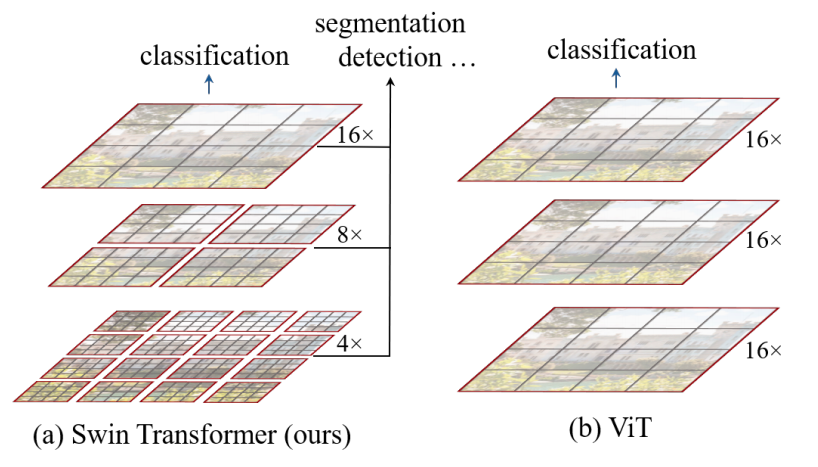

# Instalar e importar bibliotecas y librerías necesarias

In [1]:
import torch
import torch.nn as nn
from datasets import ClassLabel
import numpy as np
import torchvision.transforms as transforms
import pandas as pd

In [2]:
torch.cuda.is_available()

True

In [3]:
from datasets import Image as dsImage, Dataset

In [4]:
from evaluate import load as load_metric
from transformers import AutoFeatureExtractor, AutoImageProcessor, SwinForImageClassification
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from PIL import Image, ImageFile
from pathlib import Path
ImageFile.LOAD_TRUNCATED_IMAGES = True #imagenes ligeramente corruptas OK
import requests

# Datos

In [5]:
data = pd.read_feather("NN_INPUT.feather"); #Dataset

drop=[]
for i,r in data.iterrows():
    if not Path(f"images/{r['Path']}").exists():
        drop.append(i)

data.drop(drop,inplace=True)


data

,Path,FUM,EXP,INAC
0,2000/abr/p0423001.jpg,0.0,0.0,1.0
1,2000/abr/p0423002.jpg,1.0,0.0,0.0
2,2000/abr/p0423003.jpg,1.0,0.0,0.0
3,2000/abr/p0424001.jpg,1.0,0.0,0.0
4,2000/abr/p0424002.jpg,1.0,0.0,0.0
...,...,...,...,...
21926,2023/mar/p0316234.jpeg,1.0,0.0,0.0
21927,2023/mar/p0317231.jpeg,1.0,1.0,0.0
21928,2023/mar/p0317232.jpeg,1.0,1.0,0.0
21929,2023/mar/p0317233.jpeg,1.0,1.0,0.0


# Dataset

In [6]:
def GEN():
    for i,r in data.iterrows():
        I,F,E,N=r
        L="UNK"
        if F>0:
            if E>0:
                L="EXP+FUM"
            else:
                L="FUM"
        elif E>0:
            L="EXP"
        elif N>0:
            L="INA"
        yield {
            "image":f"images/{I}",
            "label":L
        }
Data=Dataset.from_generator(GEN)
Data=Data.cast_column("image",dsImage()).cast_column("label",ClassLabel(names=["UNK","EXP","FUM","EXP+FUM","INA"]))

In [7]:
Data=Data.train_test_split(.05)

In [8]:
labels = Data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'FUM'

In [9]:
Data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 20824
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1097
    })
})

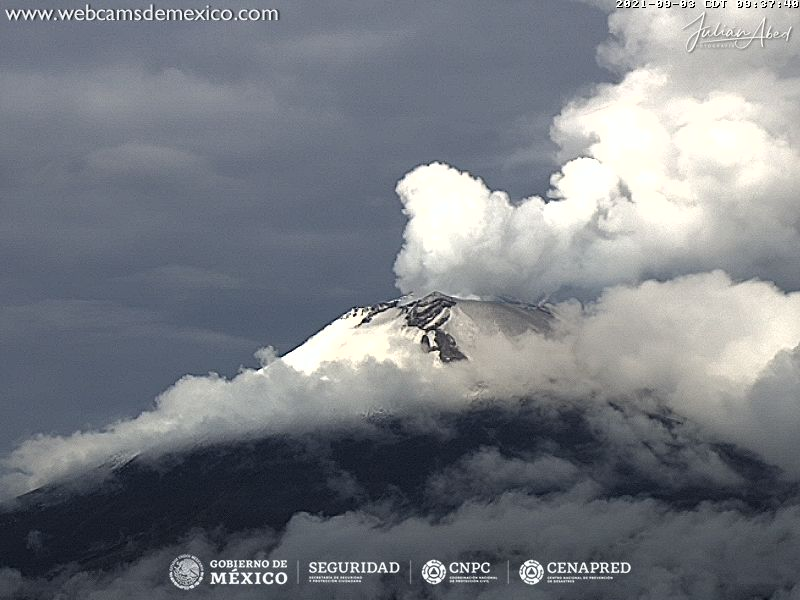

In [10]:
Data["train"][0]["image"]

In [11]:
Data["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x600>,
 'label': 2}

# Modelo

In [12]:
model_name="microsoft/swinv2-small-patch4-window16-256"

In [13]:
image_processor = AutoImageProcessor.from_pretrained(model_name)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [14]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [15]:
train_ds = Data['train']
val_ds = Data['test']

In [16]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [17]:
model = AutoModelForImageClassification.from_pretrained(
    model_name, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
).to("cuda")


Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-small-patch4-window16-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model.device

device(type='cuda', index=0)

In [19]:
metric = load_metric("accuracy")

In [20]:
model_name_b = model_name.split("/")[-1]

args = TrainingArguments(
    f"{model_name_b}-finetuned-popocatepetl",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    fp16=True,
    per_device_train_batch_size=32,
    #gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to=[]
)

In [21]:
args.device

device(type='cuda', index=0)

In [22]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [31]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [32]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)


In [33]:
trainer.model.device

device(type='cuda', index=0)

In [34]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.659100,0.579015,0.773017
2,0.698600,0.552327,0.794895
3,0.635500,0.504779,0.814038
4,0.516700,0.498007,0.819508
5,0.551000,0.498241,0.815861
6,0.554500,0.496125,0.826800
7,0.504300,0.495155,0.832270
8,0.430400,0.501322,0.825889
9,0.446700,0.522410,0.826800
10,0.402900,0.529797,0.825889


In [35]:
# rest is optional but nice to have
trainer.save_model("swinv2-small-p4-w16-i256-popo")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          10.0
  total_flos               = 11201780881GF
  train_loss               =        0.5587
  train_runtime            =    1:13:12.32
  train_samples_per_second =         47.41
  train_steps_per_second   =         1.482


In [14]:
model = AutoModelForImageClassification.from_pretrained(
    "swinv2-small-p4-w16-i256-popo",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
).to("cuda")


In [15]:
np.set_printoptions(suppress=True)

PROBABILIDADES: [0.00100107 0.00019647 0.9819505  0.01241814 0.00443374]
LA SUMA 1.0
{'UNK': 0, 'EXP': 1, 'FUM': 2, 'EXP+FUM': 3, 'INA': 4}
Predicted class: FUM
Real class: FUM


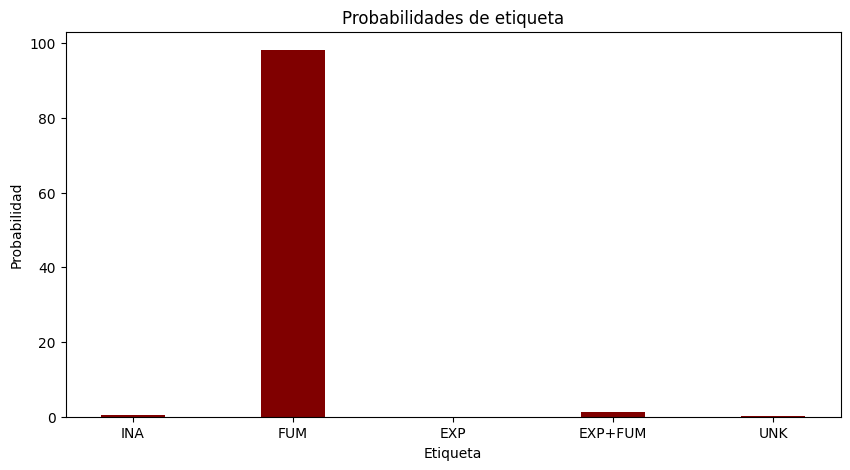

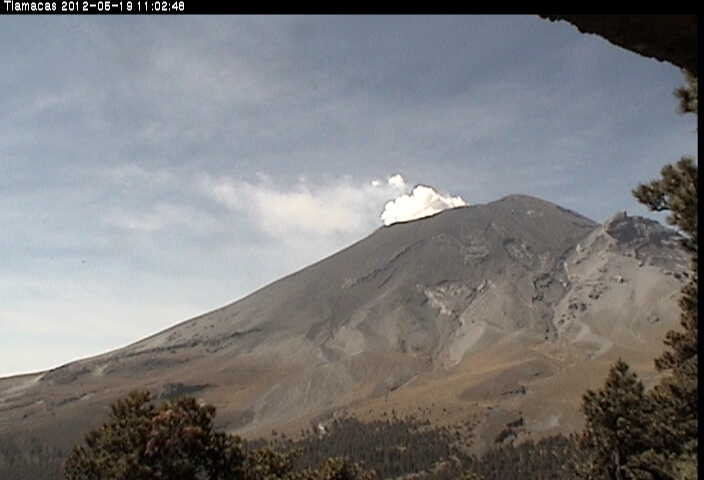

In [16]:
idx=np.random.choice(len(Data["test"]))

row=Data["test"][idx]

inputs = image_processor(images=row["image"], return_tensors="pt")["pixel_values"].to("cuda")
outputs = model(pixel_values=inputs)
logits = outputs.logits
#logits=model(**inputs).logits
#print("LOGITS:",logits)

probabilities = nn.functional.softmax(logits, dim=-1)
probabilities = probabilities.detach().cpu().numpy().flatten()
print("PROBABILIDADES:",probabilities)
print("LA SUMA",probabilities.sum())
print(model.config.label2id)

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])
print("Real class:",model.config.id2label[row["label"]])
#print(probabilities*100)
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
display_labels=["INA","FUM","EXP","EXP+FUM","UNK"]
# creating the bar plot
plt.bar(display_labels, [probabilities[model.config.label2id[x]]*100 for x in display_labels], color ='maroon', width = 0.4)
 
plt.xlabel("Etiqueta")
plt.ylabel("Probabilidad")
plt.title("Probabilidades de etiqueta")
plt.show()
row["image"]